In [1]:
import pandas as pd
import numpy as np
from sksurv.nonparametric import kaplan_meier_estimator as kmf
import matplotlib.pyplot as plt
from lifelines.statistics import logrank_test
import matplotlib.patches as mpatches

In [2]:
selected_cell = 'Stellate cells'

In [3]:
estimation = pd.read_csv('GSE14520.Mesenchyme.csv',index_col=0)
estimation.head()

Other  Hepatocytes  Proliferation     vSMC  Stellate cells  \
Mixture                                                                    
GSM362947  0.317488     0.564370            0.0  0.00000        0.000000   
GSM362948  0.398708     0.444058            0.0  0.00000        0.000000   
GSM362949  0.400777     0.476645            0.0  0.01351        0.050370   
GSM362950  0.443174     0.407487            0.0  0.00000        0.006810   
GSM362951  0.292158     0.575179            0.0  0.00000        0.113485   

               CAFs  Pericytes  P-value  Correlation      RMSE  
Mixture                                                         
GSM362947  0.027042   0.091100        0     0.807009  0.722186  
GSM362948  0.100680   0.056555        0     0.809021  0.613261  
GSM362949  0.018136   0.040560        0     0.861145  0.542014  
GSM362950  0.077935   0.064594        0     0.849685  0.530998  
GSM362951  0.000000   0.019179        0     0.821149  0.711933

In [4]:
survival_data = pd.read_csv('GSE14520.Survival.csv',index_col=0)
survival_data.head()

OS_E    OS  DFS_E   DFS
GSM                               
GSM363205     0  58.0      0  58.0
GSM363115     0  66.6      0  66.6
GSM362970     0  67.3      0  67.3
GSM363354     1  10.4      1  10.4
GSM363039     0  52.8      0  52.8

In [5]:
dfs_data = survival_data.filter(['DFS_E', 'DFS'])
dfs_data = dfs_data.dropna(axis=0,how='any')
binary = {1:True,0:False}
dfs_data['DFS_E'] = [binary[event] for event in dfs_data['DFS_E']]
dfs_data['DFS_T'] = [time for time in dfs_data['DFS']]
dfs_data.head()

DFS_E   DFS  DFS_T
GSM                          
GSM363205  False  58.0   58.0
GSM363115  False  66.6   66.6
GSM362970  False  67.3   67.3
GSM363354   True  10.4   10.4
GSM363039  False  52.8   52.8

In [6]:
survival_test = estimation.merge(dfs_data,left_index=True,right_index=True,how='inner')
survival_test.head()

Other  Hepatocytes  Proliferation     vSMC  Stellate cells  \
GSM362947  0.317488     0.564370            0.0  0.00000         0.00000   
GSM362948  0.398708     0.444058            0.0  0.00000         0.00000   
GSM362949  0.400777     0.476645            0.0  0.01351         0.05037   
GSM362950  0.443174     0.407487            0.0  0.00000         0.00681   
GSM362952  0.288244     0.638074            0.0  0.00000         0.00000   

               CAFs  Pericytes  P-value  Correlation      RMSE  DFS_E   DFS  \
GSM362947  0.027042   0.091100        0     0.807009  0.722186   True  50.0   
GSM362948  0.100680   0.056555        0     0.809021  0.613261   True   8.8   
GSM362949  0.018136   0.040560        0     0.861145  0.542014   True  18.2   
GSM362950  0.077935   0.064594        0     0.849685  0.530998   True  30.1   
GSM362952  0.006728   0.066953        0     0.841236  0.758716  False  54.3   

           DFS_T  
GSM362947   50.0  
GSM362948    8.8  
GSM362949   18.2  
GSM362950   30.1  
GSM362952   54.3

In [7]:
survival_reorder = survival_test.sort_values(selected_cell,axis=0,ascending=False)
survival_reorder.head()

Other  Hepatocytes  Proliferation      vSMC  Stellate cells  \
GSM363393  0.257044     0.211588            0.0  0.108321        0.185163   
GSM363294  0.297093     0.391807            0.0  0.000000        0.163853   
GSM362971  0.204775     0.641622            0.0  0.002402        0.139283   
GSM363335  0.236479     0.612176            0.0  0.000000        0.124718   
GSM363008  0.231921     0.538366            0.0  0.010792        0.121036   

               CAFs  Pericytes  P-value  Correlation      RMSE  DFS_E   DFS  \
GSM363393  0.029763   0.208120        0     0.102369  1.102918   True   4.0   
GSM363294  0.100178   0.047068        0     0.829032  0.562549  False  62.6   
GSM362971  0.000000   0.011918        0     0.867469  0.714822   True  40.4   
GSM363335  0.000000   0.026628        0     0.867777  0.672459  False  59.4   
GSM363008  0.097885   0.000000        0     0.922072  0.461550   True  23.6   

           DFS_T  
GSM363393    4.0  
GSM363294   62.6  
GSM362971   40.4  
GSM363335   59.4  
GSM363008   23.6

In [8]:
running_length = len(survival_reorder)

logrank_tests = []
cut_points = []

for i in range(running_length):
    cut_point = int(i+1)
    E = list(survival_reorder['DFS_E'])
    mid_point = int(len(E)/2)
    E_high = E[:cut_point]
    E_low = E[cut_point:]
    S = list(survival_reorder['DFS_T'])
    S_high = S[:cut_point]
    S_low = S[cut_point:]
    results = logrank_test(S_high,S_low,E_high,E_low)
    p = results.p_value
    cut_points.append(cut_point)
    logrank_tests.append(p)

optimization = pd.DataFrame(logrank_tests,index=cut_points,columns=['Log Rank Test'])

In [13]:
#optimization = optimization.dropna()
#optimization = optimization.sort_values('Log Rank Test')
#optimization = int(optimization.iloc[0].name)
optimization = int(len(E)/2)

In [14]:
dfs_cut_level = survival_reorder[selected_cell][optimization]
dfs_cut_level

0.00121829688609465

In [15]:
E = list(survival_reorder['DFS_E'])
cut_point = optimization
E_high = E[:cut_point]
E_low = E[cut_point:]
S = list(survival_reorder['DFS_T'])
S_high = S[:cut_point]
S_low = S[cut_point:]
results = logrank_test(S_high,S_low,E_high,E_low)
p = results.p_value
p = round(p,5)
p

0.50724

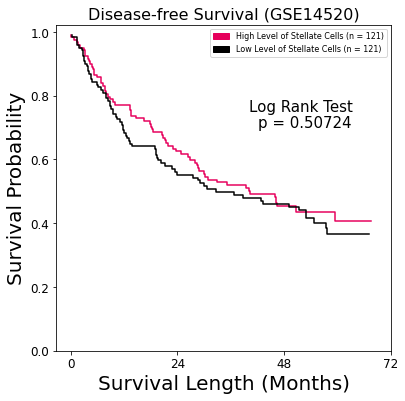

In [16]:
plt.figure(figsize=(6,6))
t,s = kmf(E_high, S_high)
plt.step(t,s,c='#e6005c')
t,s = kmf(E_low, S_low)
plt.step(t,s,c='k')
plt.xticks(np.arange(0,73,24),fontsize=12)
plt.yticks(np.arange(0,1.1,0.2),fontsize=12)
plt.xlabel('Survival Length (Months)', fontsize=20)
plt.ylabel('Survival Probability',fontsize=20)
high_patch = mpatches.Patch(color='#e6005c',label='High Level of Stellate Cells (n = %s)'%len(E_high))
low_patch = mpatches.Patch(color='k',label='Low Level of Stellate Cells (n = %s)'%len(E_low))
plt.text(40,0.75, 'Log Rank Test',fontsize=15)
plt.text(42,0.7, 'p = %s'%p,fontsize=15)
plt.legend(handles=[high_patch,low_patch],fontsize=8)
plt.title('Disease-free Survival (GSE14520)',fontsize=16)
plt.savefig('GSE14520.%s.DFS.pdf'%selected_cell,format='pdf')

In [17]:
os_data = survival_data.filter(['OS_E', 'OS'])
os_data = os_data.dropna(axis=0,how='any')
binary = {1:True,0:False}
os_data['OS_E'] = [binary[event] for event in os_data['OS_E']]
os_data['OS_T'] = [time for time in os_data['OS']]
os_data.head()

OS_E    OS  OS_T
GSM                         
GSM363205  False  58.0  58.0
GSM363115  False  66.6  66.6
GSM362970  False  67.3  67.3
GSM363354   True  10.4  10.4
GSM363039  False  52.8  52.8

In [18]:
survival_test = estimation.merge(os_data,left_index=True,right_index=True,how='inner')
survival_test.head()

Other  Hepatocytes  Proliferation     vSMC  Stellate cells  \
GSM362947  0.317488     0.564370            0.0  0.00000         0.00000   
GSM362948  0.398708     0.444058            0.0  0.00000         0.00000   
GSM362949  0.400777     0.476645            0.0  0.01351         0.05037   
GSM362950  0.443174     0.407487            0.0  0.00000         0.00681   
GSM362952  0.288244     0.638074            0.0  0.00000         0.00000   

               CAFs  Pericytes  P-value  Correlation      RMSE   OS_E    OS  \
GSM362947  0.027042   0.091100        0     0.807009  0.722186   True  59.2   
GSM362948  0.100680   0.056555        0     0.809021  0.613261  False  61.4   
GSM362949  0.018136   0.040560        0     0.861145  0.542014   True  18.2   
GSM362950  0.077935   0.064594        0     0.849685  0.530998  False  57.5   
GSM362952  0.006728   0.066953        0     0.841236  0.758716  False  54.3   

           OS_T  
GSM362947  59.2  
GSM362948  61.4  
GSM362949  18.2  
GSM362950  57.5  
GSM362952  54.3

In [19]:
survival_reorder = survival_test.sort_values(selected_cell,axis=0,ascending=False)
survival_reorder

Other  Hepatocytes  Proliferation      vSMC  Stellate cells  \
GSM363393  0.257044     0.211588       0.000000  0.108321        0.185163   
GSM363294  0.297093     0.391807       0.000000  0.000000        0.163853   
GSM362971  0.204775     0.641622       0.000000  0.002402        0.139283   
GSM363335  0.236479     0.612176       0.000000  0.000000        0.124718   
GSM363008  0.231921     0.538366       0.000000  0.010792        0.121036   
...             ...          ...            ...       ...             ...   
GSM363194  0.323710     0.441650       0.150434  0.000000        0.000000   
GSM363198  0.331737     0.571719       0.000000  0.000000        0.000000   
GSM363200  0.348708     0.523667       0.000000  0.000000        0.000000   
GSM363204  0.368421     0.482057       0.000000  0.000000        0.000000   
GSM363182  0.255224     0.698347       0.000000  0.000000        0.000000   

               CAFs  Pericytes  P-value  Correlation      RMSE   OS_E    OS  \
GSM363393  0.029763   0.208120        0     0.102369  1.102918   True   4.0   
GSM363294  0.100178   0.047068        0     0.829032  0.562549  False  62.6   
GSM362971  0.000000   0.011918        0     0.867469  0.714822   True  48.1   
GSM363335  0.000000   0.026628        0     0.867777  0.672459  False  59.4   
GSM363008  0.097885   0.000000        0     0.922072  0.461550  False  58.4   
...             ...        ...      ...          ...       ...    ...   ...   
GSM363194  0.066912   0.017294        0     0.762892  0.681034  False   4.5   
GSM363198  0.011134   0.085410        0     0.444991  1.196266  False  57.9   
GSM363200  0.029182   0.098443        0     0.815823  0.663483   True  23.9   
GSM363204  0.087064   0.062458        0     0.854398  0.558317   True  14.1   
GSM363182  0.017506   0.028923        0     0.861475  0.813855  False  52.7   

           OS_T  
GSM363393   4.0  
GSM363294  62.6  
GSM362971  48.1  
GSM363335  59.4  
GSM363008  58.4  
...         ...  
GSM363194   4.5  
GSM363198  57.9  
GSM363200  23.9  
GSM363204  14.1  
GSM363182  52.7  

[242 rows x 13 columns]

In [20]:
running_length = len(survival_reorder)

logrank_tests = []
cut_points = []

for i in range(running_length):
    cut_point = int(i+1)
    E = list(survival_reorder['OS_E'])
    mid_point = int(len(E)/2)
    E_high = E[:cut_point]
    E_low = E[cut_point:]
    S = list(survival_reorder['OS_T'])
    S_high = S[:cut_point]
    S_low = S[cut_point:]
    results = logrank_test(S_high,S_low,E_high,E_low)
    p = results.p_value
    cut_points.append(cut_point)
    logrank_tests.append(p)

optimization = pd.DataFrame(logrank_tests,index=cut_points,columns=['Log Rank Test'])

In [21]:
#optimization = optimization.dropna()
#optimization = optimization.sort_values('Log Rank Test')
#optimization = int(optimization.iloc[0].name)
optimization = int(len(E)/2)

In [22]:
os_cut_level = survival_reorder[selected_cell][optimization]
os_cut_level

0.00121829688609465

In [23]:
E = list(survival_reorder['OS_E'])
cut_point = optimization
E_high = E[:cut_point]
E_low = E[cut_point:]
S = list(survival_reorder['OS_T'])
S_high = S[:cut_point]
S_low = S[cut_point:]
results = logrank_test(S_high,S_low,E_high,E_low)
p = results.p_value
p = round(p,5)
p

0.73283

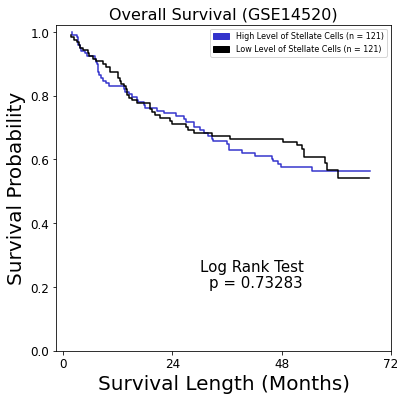

In [24]:
plt.figure(figsize=(6,6))
t,s = kmf(E_high, S_high)
plt.step(t,s,c='#3333cc')
t,s = kmf(E_low, S_low)
plt.step(t,s,c='k')
plt.xticks(np.arange(0,73,24),fontsize=12)
plt.yticks(np.arange(0,1.1,0.2),fontsize=12)
plt.xlabel('Survival Length (Months)', fontsize=20)
plt.ylabel('Survival Probability',fontsize=20)
high_patch = mpatches.Patch(color='#3333cc',label='High Level of Stellate Cells (n = %s)'%len(E_high))
low_patch = mpatches.Patch(color='k',label='Low Level of Stellate Cells (n = %s)'%len(E_low))
plt.text(30,0.25, 'Log Rank Test',fontsize=15)
plt.text(32,0.2, 'p = %s'%p,fontsize=15)
plt.legend(handles=[high_patch,low_patch],fontsize=8)
plt.title('Overall Survival (GSE14520)',fontsize=16)
plt.savefig('GSE14520.%s.OS.pdf'%selected_cell,format='pdf')

In [25]:
estimation = estimation.sort_values(selected_cell,ascending=False)
x = []
y = []
for key,value in enumerate(estimation[selected_cell]):
    x.append(key)
    y.append(value)

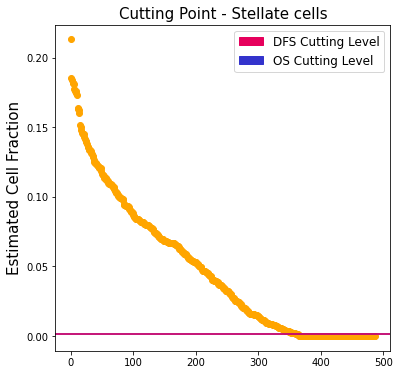

In [26]:
plt.figure(figsize=(6,6))
plt.scatter(x,y,color='orange')
plt.axhline(y=os_cut_level, xmin=0, xmax=100,color='#3333cc')
plt.axhline(y=dfs_cut_level, xmin=0, xmax=100,color='#e6005c')
plt.ylabel('Estimated Cell Fraction',fontsize=15)
plt.title('Cutting Point - %s'%selected_cell,fontsize=15)
dfs_patch = mpatches.Patch(color='#e6005c',label='DFS Cutting Level')
os_patch = mpatches.Patch(color='#3333cc',label='OS Cutting Level')
plt.legend(handles=[dfs_patch,os_patch],fontsize=12)
plt.savefig('Cutting_Point.%s'%selected_cell,format='pdf')